In [1]:
#Import des librairies Python
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.cluster import hierarchy
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import decomposition
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from functions import *
import statsmodels.formula.api as smf
from sklearn.metrics import pairwise_distances_argmin_min
import scipy.stats as st
from collections import Counter
from tqdm import tqdm 
import pickle

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
cwd = os.getcwd()
cwd

'C:\\Users\\NA00025036\\Desktop\\autrs\\nayescha\\07 - PrédictionDesRevenus'

**Scénario**

Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.

Cependant, elle souhaite cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus.

L'équipe dans laquelle vous travaillez a donc reçu pour mission de créer un modèle permettant de déterminer le revenu potentiel d'une personne.Très bien.

"Quelles informations avons-nous ?" demandez-vous à votre supérieur, qui vous répond : "À vrai dire... quasiment aucune : uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent. C'est tout ! Ah oui, une dernière chose : ce modèle doit être valable pour la plupart des pays du monde. Je vous laisse méditer là-dessus… Bon courage !"

Avec aussi peu de données disponibles, cela semble être un sacré challenge !

Ainsi, vous proposez une régression linéaire avec 3 variables :

* le revenu des parents ;
* le revenu moyen du pays dans lequel habite le prospect ;
* l'indice de Gini calculé sur les revenus des habitants du pays en question. 

# Mission 1
Résumez les données utilisées :

* année(s) des données utilisées ;
* nombre de pays présents ;
* population couverte par l'analyse (en termes de pourcentage de la population mondiale).

In [4]:
#Téléchargement du fichier de base clients
data = pd.read_csv(cwd + '/data/data-projet7.csv')
data.rename(columns={'country': 'Country Code'},  inplace=True)

#Téléchargement du fichier de base clients
data = pd.read_csv(cwd + '/data/data-projet7.csv')
data.rename(columns={'country': 'Country Code'},  inplace=True)

#Transformer la colonne income et gdpppp en nombre pour pouvoir l'utiliser pour les calculs à venir
data['income'] = [x.replace(',', '.') for x in data['income']]
data['income'] = pd.to_numeric(data['income'])
data['gdpppp'] = data['gdpppp'].astype(str)
data['gdpppp'] = [x.replace(',', '.') for x in data['gdpppp']]

#Recherche d'éventuelles valeurs en doublon avec la fonction .duplicated()
print(str(data.duplicated().sum()) + " données en double")
print(" ")
#Recherche d'éventuelles valeurs nulles
print("valeurs nulles par colonne :")
print(str(data.isna().any()))
print(" ")
#Affichage des années utilisées dans la base
années_analyse = data['year_survey'].unique()
print("Années utilisées dans la base : " + str(années_analyse))

0 données en double
 
valeurs nulles par colonne :
Country Code    False
year_survey     False
quantile        False
nb_quantiles    False
income          False
gdpppp          False
dtype: bool
 
Années utilisées dans la base : [2008 2009 2010 2007 2006 2011 2004]


In [5]:
#Vérification de la quantité des pays dans la base
nbr_pays = data.copy()
nbr_pays['nbr'] = 1
nbr_pays = nbr_pays[['Country Code', 'nbr']]
nbr_pays = nbr_pays[['Country Code', 'nbr']].groupby('Country Code').sum().reset_index()
print( "La base a " + str(nbr_pays['Country Code'].count()) + " pays")

#Agrégation des données selon les pays, puis application d'une fonction .nunique()
data_nunique = data.groupby('Country Code').nunique()
data_nunique[data_nunique['quantile'] < 100]


La base a 116 pays


,year_survey,quantile,nb_quantiles,income,gdpppp
Country Code,,,,,
LTU,1,99,1,99,1


In [6]:
#Visualisation des 99 individus du pays 'LTU'
with pd.option_context('display.max_rows', 100):
    print(data[data['Country Code'] == 'LTU']['quantile'].tolist())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [7]:
#Calcul du quantile manquant (41)par la moyenne des quantiles -1 et +1 (40 et 42)
ltu_41 = data.loc[(data['Country Code'] == 'LTU') & (data['quantile'] == 40) 
                  | (data['Country Code'] == 'LTU') & (data['quantile'] == 42)]['income'].mean()

#Création de la ligne manquante selon le pays 'LTU' & quantile '41'
ltu_41_row = pd.DataFrame({'Country Code': ['LTU'], 'year_survey': [2008], 'quantile': [41], 
                           'nb_quantiles': [100], 'income': [ltu_41], 'gdpppp': 17571.0})

#Intégration de la précédente ligne dans le dataframe "data"
data = pd.concat([data, ltu_41_row], join="inner")

#Téléchargement du fichier avec l'index gini
gini = pd.read_csv(cwd + '/data/API_SI.POV.GINI_DS2_en_csv_v2_2445276.csv')
pop = pd.read_csv(cwd + '/data/population.csv')
code_pays = gini[['Country Name', 'Country Code']]

#Identification des mêmes années que celles de l'échantillon "df"
gini_columns = []
for value in gini.columns:
    gini_columns.append(value)
    
gini_vars = [year for year in gini_columns if year in (['2004', '2006', '2007', '2008', '2009', '2010', '2011'])]

#Mise en forme du dataframe pour obtenir uniquement les indices de Gini disponibles sur les années ci-dessus
gini_melt = pd.melt(gini, id_vars =['Country Code', 'Country Name'], value_vars = gini_vars, var_name ='year', 
                    value_name ='gini')
gini_melt['gini'] = round(gini_melt['gini']/100, 2)
gini_melt.dropna(inplace=True)
gini_melt['year'] = gini_melt['year'].astype(int)

In [8]:
#Création du dataframe population
population = pop.copy()
population['Value'] = population['Value']*1000
population = population[['Area Code (ISO3)','Area', 'Value']]
population.rename(columns={'Area Code (ISO3)': 'Country Code', 'Area': 'Country Name'},  inplace=True)

#Liste des noms des pays dans le dataframe population
print("Quantité des pays dans le df population: " + str(population['Country Name'].count()))
#Liste des noms des pays dans le dataframe de base
print("Quantité des pays dans le df de base: " + str(code_pays['Country Name'].count()))

Quantité des pays dans le df population: 237
Quantité des pays dans le df de base: 264


In [9]:
#Vérification des correspondaces nom pays / code pays d'après notre dataframe de base "data" 
data_code = data.copy()
data_code = data_code[['Country Code']]

data_pays_code = pd.merge(data_code, code_pays, on='Country Code', how='left')
data_pays_code = data_pays_code.drop_duplicates()
data_pays_code

,Country Code,Country Name
0,ALB,Albania
100,ARG,Argentina
200,ARM,Armenia
300,AUT,Austria
400,AZE,Azerbaijan
...,...,...
11099,VNM,Vietnam
11199,PSE,West Bank and Gaza
11299,YEM,NaN
11399,ZAF,South Africa


In [10]:
#Vérification des correspondaces nom pays / code pays d'après notre dataframe de base "data" 
data_code = data.copy()
data_code = data_code[['Country Code']]

data_pays_code = pd.merge(data_code, code_pays, on='Country Code', how='left')
data_pays_code = data_pays_code.drop_duplicates()

#Filtre pour avoir la liste de ces pays sans nom
filtre = data_pays_code["Country Name"].isnull()
data_pays_code[filtre]

,Country Code,Country Name
2800,EGY,NaN
4600,IRN,NaN
5700,KOR,NaN
10399,TWN,NaN
10999,VEN,NaN
11299,YEM,NaN
11499,COD,NaN


In [11]:
#Création d'un dataframe avec les correspondances des codes sans nom de pays
code_nan = pd.DataFrame({'Country Code': ['EGY', 'IRN', 'KOR', 'TWN', 'VEN', 'YEM', 'COD'], 'Country Name': ['Egypt', 'Iran (Islamic Republic of)', "Democratic People's Republic of Korea", 'China, Taiwan Province of', 'Venezuela (Bolivarian Republic of)', 'Yemen', 'Congo']})

#Suppresion des lignes avec des NaN
index_with_nan = data_pays_code.index[data_pays_code.isnull().any(axis=1)]
data_pays_code.drop(index_with_nan,0, inplace=True)

#Ajout des codes pays et nom pays pour les pays manquants
data_pays_code_name = pd.concat([data_pays_code, code_nan], axis=0)
data_pays_code_name.reset_index()

#Vérification que le dataframe "data_pays_code_name" n'a pas des valeures nulles ni doublons
print(data_pays_code_name.isna().any())
print( )
print('Le dataframe des correspondances code/nom pays a ' + str(data_pays_code_name.duplicated().sum()) + " doublons")

Country Code    False
Country Name    False
dtype: bool

Le dataframe des correspondances code/nom pays a 0 doublons


In [12]:
#Ajout des codes pays manquants dans le dataframe population
data_pop = pd.merge(data_pays_code_name, population, on='Country Code', how='left')
data_pop = data_pop.drop(['Country Name_y'], axis=1)
data_pop.rename(columns={'Country Name_x': 'Country Name'},  inplace=True)

#Vérification si il y a des valeurs nulles dans le dataframe data_pop
print("Valeurs nulles dataframe data_pop : ")
print(str(data_pop.isna().any()))


#Vérification des pays sans donnée population
filtre_pop = data_pop.copy()
filtre_pop = filtre_pop['Value'].isnull()
pop_nan = data_pop[filtre_pop]

#Remlir le valeur manquant dans le dataframe data_pop
data_pop.loc[55, 'Value'] = 1920079

#2ème vérification si il y a des valeurs nulles dans le dataframe data_pop
print("  ")
print("2 émé verification des valeurs nulles dataframe data_pop : ")
print(str(data_pop.isna().any()))


Valeurs nulles dataframe data_pop : 
Country Code    False
Country Name    False
Value            True
dtype: bool
  
2 émé verification des valeurs nulles dataframe data_pop : 
Country Code    False
Country Name    False
Value           False
dtype: bool


In [13]:
#Calcul de la population mondiale reprensenté dans par l'échantillon
population_base = data_pop['Value'].sum()
population_mond = population['Value'].sum()
rapport_pops = (population_base/population_mond)*100.

print( "La base a " + str(nbr_pays['Country Code'].count()) + " pays")
print("Années utilisées dans la base : " + str(sorted(années_analyse)))
print("Nous avons dans la base " + str("%.2f"%(population_base)) + " personnes, \
soit "+ str("%.2f"%(rapport_pops)) + "% de la population mondiale")

La base a 116 pays
Années utilisées dans la base : [2004, 2006, 2007, 2008, 2009, 2010, 2011]
Nous avons dans la base 6978073099.00 personnes, soit 76.76% de la population mondiale


Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective.

* De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
* Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

**Nous appellerons ici chaque quantile une classe de revenu.
Ainsi, la valeur de la colonne income pour un quantile donné peut être vue comme le revenu moyen des personnes appartenant à la classe de revenu correspondante à ce quantile.**

L'unité utilisée dans la colonne income de la world income distribution est le $PPP. Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc. Après vous être documenté, vous expliquerez à votre mentor très brièvement à quoi correspond cette unité et pourquoi elle est pertinente pour une comparaison de pays différents (Il n'est pas nécessaire de donner cette explication lors de la soutenance).
__________________________________________________________________________________________________________________

La notion de quantile (ou de fractile) est le terme général pour désigner les valeurs qui divisent un jeu de données en intervalles contenant le même nombre de données. Il y a donc un quantile de moins que le nombre de groupes créés puisqu'en divisant une population en n il y a bien n-1 quantiles.

([<matplotlib.axis.XTick at 0x1cb34604790>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

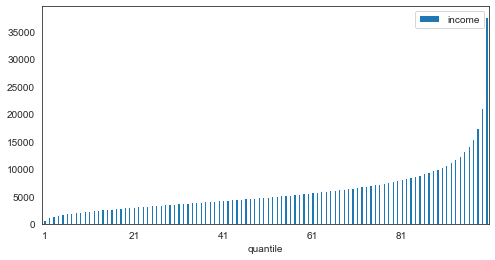

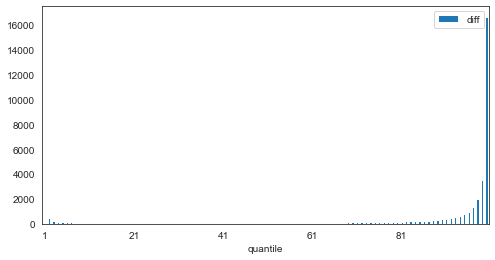

In [53]:
labels = ['20', '40', '60', '80', '100']
#Regroupement des quantiles en faisant leur moyenne
df_quantile = data[['quantile', 'income']].groupby('quantile').agg({'income': ['mean']}).reset_index()
df_quantile.columns = ['quantile', 'income']

#Vérification des écarts entre les quantiles en $
df_quantile['diff'] = df_quantile['income'].diff()

#Affichage d'un plot bar pour vérifier la distribuition de la moyenne des quantiles 
df_quantile.plot.bar(x='quantile', y='income', rot=0, figsize=(8,4))
plt.xticks(np.arange(0,100, 20))
# et la distribuition des écarts entre les quantiles
df_quantile.plot.bar(x='quantile', y='diff', rot=0, figsize=(8,4))
plt.xticks(np.arange(0,100, 20))

([<matplotlib.axis.XTick at 0x1cb10fc4ee0>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

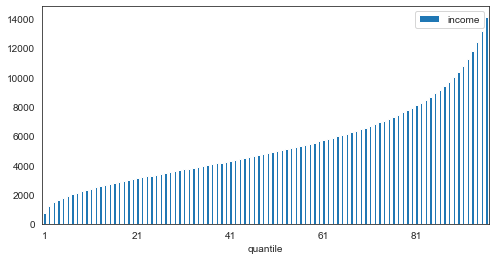

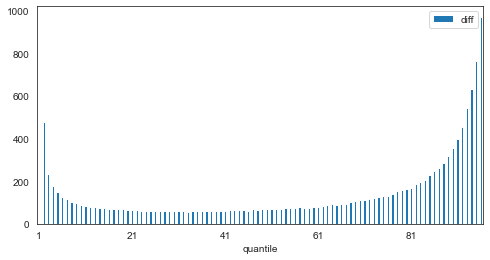

In [54]:
#Suppression des quantiles 100, 99, 98, 97 car trop d'écart pour vérifier si la distribuition est homogène 
df_quantile_ss = df_quantile.copy()
df_quantile_ss = df_quantile_ss[df_quantile_ss['quantile'] != 100]
df_quantile_ss = df_quantile_ss[df_quantile_ss['quantile'] != 99]
df_quantile_ss = df_quantile_ss[df_quantile_ss['quantile'] != 98]
df_quantile_ss = df_quantile_ss[df_quantile_ss['quantile'] != 97]
df_quantile_ss.plot.bar(x='quantile', y='income', rot=0, figsize=(8,4))
plt.xticks(np.arange(0,100, 20))
df_quantile_ss.plot.bar(x='quantile', y='diff', rot=0, figsize=(8,4))
plt.xticks(np.arange(0,100, 20))

([<matplotlib.axis.XTick at 0x1cb344d0e50>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

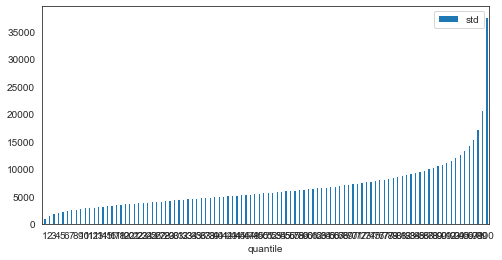

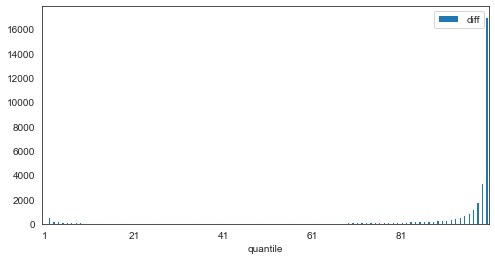

In [59]:
#Régoupemment des quantiles par la variance std et visualisation des distribuitions
df_quantile_std = data[['quantile', 'income']].groupby('quantile').agg({'income': ['std']}).reset_index()
df_quantile_std['diff'] = df_quantile_std['income'].diff()
df_quantile_std.plot.bar(x='quantile', y='income', rot=0, figsize=(8,4))
df_quantile_std.plot.bar(x='quantile', y='diff', rot=0, figsize=(8,4))
plt.xticks(np.arange(0,100, 20))

([<matplotlib.axis.XTick at 0x1cb1146cfd0>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

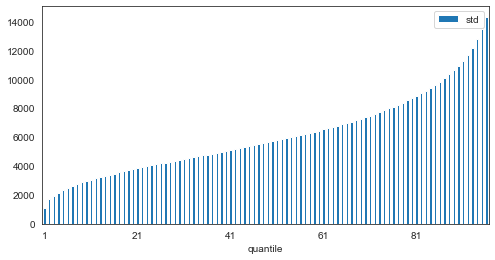

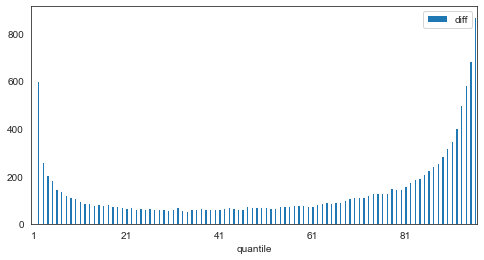

In [56]:
#Suppression des quantiles 100, 99, 98, 97 car trop d'écart pour vérifier si la distribuition des variances est homogène 
df_quantile_ss_std = df_quantile_std.copy()
df_quantile_ss_std = df_quantile_ss_std[df_quantile_ss_std['quantile'] != 100]
df_quantile_ss_std = df_quantile_ss_std[df_quantile_ss_std['quantile'] != 99]
df_quantile_ss_std = df_quantile_ss_std[df_quantile_ss_std['quantile'] != 98]
df_quantile_ss_std = df_quantile_ss_std[df_quantile_ss_std['quantile'] != 97]
df_quantile_ss_std.plot.bar(x='quantile', y='income', rot=0, figsize=(8,4))
plt.xticks(np.arange(0,100, 20))
df_quantile_ss_std.plot.bar(x='quantile', y='diff', rot=0, figsize=(8,4))
plt.xticks(np.arange(0,100, 20))

# Mission 2

* Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
* Représentez la courbe de Lorenz de chacun des pays choisis.
* Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
* Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

In [18]:
data.iloc[5811:5821]

,Country Code,year_survey,quantile,nb_quantiles,income,gdpppp
5811,XKX,2008,12,100,959.44720,nan
5812,XKX,2008,13,100,986.60974,nan
5813,XKX,2008,14,100,1006.39140,nan
5814,XKX,2008,15,100,1028.35720,nan
5815,XKX,2008,16,100,1052.11940,nan
5816,XKX,2008,17,100,1076.16330,nan
5817,XKX,2008,18,100,1097.54080,nan
5818,XKX,2008,19,100,1121.99760,nan
5819,XKX,2008,20,100,1146.63530,nan
5820,XKX,2008,21,100,1171.98680,nan


In [19]:
#Remplissage des valeurs manquants pour le gdppp
mask = data['Country Code'].str.startswith('XKX')
data.loc[mask, 'gdpppp'] = 7249.357

mask2 = data['Country Code'].str.startswith('PSE')
data.loc[mask2, 'gdpppp'] = 2035.20

#Renommage des colonnes
df = pd.merge(data, data_pop, on='Country Code', how='left')
df.rename(columns={'Value': 'Population','year_survey': 'year' },  inplace=True)

#Jointure des indices de Gini "gini_melt" avec l'échantillon "df"
df = pd.merge(df, gini_melt, how='left', on=['Country Code', 'Country Name', 'year'])

#Vérification des pays sans donnée GINI
filtre_df = df.copy()
filtre_df = filtre_df['gini'].isnull()
df_nan = df[filtre_df]
df_nan = df_nan[['Country Code', 'Country Name', 'gini']]
df_nan = df_nan.drop_duplicates()
df_nan.count()

Country Code    29
Country Name    29
gini             0
dtype: int64

In [20]:
data.iloc[5750:5821]

,Country Code,year_survey,quantile,nb_quantiles,income,gdpppp
5750,KOR,2008,51,100,12926.3760,19162
5751,KOR,2008,52,100,13122.7770,19162
5752,KOR,2008,53,100,13315.4630,19162
5753,KOR,2008,54,100,13479.1320,19162
5754,KOR,2008,55,100,13690.5360,19162
...,...,...,...,...,...,...
5816,XKX,2008,17,100,1076.1633,7249.36
5817,XKX,2008,18,100,1097.5408,7249.36
5818,XKX,2008,19,100,1121.9976,7249.36
5819,XKX,2008,20,100,1146.6353,7249.36


In [21]:
#Isolement des pays selon les années dont l'indice de Gini est manquant
missing_gini = df[df.isna().any(axis=1)].drop_duplicates(subset=['Country Code', 'quantile', 'year'])

#Calcul des indices de Gini manquants
list_gini = []
for code in missing_gini['Country Code'] : 
    dep = missing_gini[missing_gini['Country Code'] == code]['income'].values
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()

    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
    S = 0.5 - AUC 
    Gini = round(2*S, 2)
    list_gini.append(Gini)
    
#Intégration des indices de Gini dans le dataframe "find_gini" issu de "missing_gini"
find_gini = missing_gini.copy()
find_gini.loc[:,'gini'] = list_gini

#Intégration des valeurs manquantes dans l'échantillon "df"
for code in list(find_gini['Country Code'].unique()) :
    df.loc[df['Country Code'] == code,'gini'] = (find_gini.loc[find_gini['Country Code'] == code,'gini'])
    
#Clustering fait à partir d'une copie de l'échantillon, ici nommée "df_clustering"
df_clustering = df.copy()
df_clustering = df_clustering[df_clustering['Country Name'] != 'Fiji']

La visualisation précédente des distributions de nos variables avait exposée quelques outliers. Le pays Fiji sera exclu du clustering car sa valeur du gdpppp est très influente.

In [22]:
#Transformation en array Numpy
#Indexation selon les pays par la fonction .set_index()
df_clustering.set_index('Country Name', inplace=True)

#Par simplification (gain en temps de calcul), le clustering sera fait sur le premier quantile
#Suppression des lignes par méthode .drop_duplicates()
df_clustering.drop_duplicates(subset=['Country Code'], inplace=True)

#Préparation des données pour le clustering K-Means
#Ici le clustering sera établi sur les valeurs des variables 'gdpppp' et 'gini'
X = df_clustering.loc[:, ['gdpppp', 'gini', 'Population', 'income']].values
Y = df_clustering.index

display(X.shape)
display(Y.shape)

(115, 4)

(115,)

Le .shape me permet de vérifier que les 116 pays (moins le pays Fiji) sont toujours dans les données à clusteriser, y compris les deux variables descriptives.

In [23]:
#Centrage / réduction des données (nécessaire pour éviter les décalages d'échelle)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
X_scaled.shape

(115, 4)

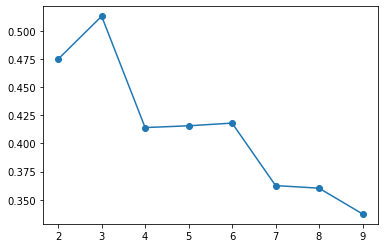

In [24]:
#Calcul  de la métrique "silhouette" pour différents nombres de groupes issus de la méthode des centres mobiles
#Liste pour stocker nos coefficients
silhouettes = [] 

#Boucle itérative de 2 à 10 (clusters) pour tester les possibilités
for k in range(2, 10): 
    #Création et ajustement d'un modèle pour chaque k
    cls = cluster.KMeans(n_clusters=k)  
    cls.fit(X_scaled)
    
    #Stockage des coefficients associés
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)
    
#Visualisation des valeurs de coefficient de silhouette pour chaque nombre de cluster
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

In [25]:
nb_cluster = 10

cls = cluster.KMeans(n_clusters=nb_cluster)
cls.fit(X_scaled)
centroids = cls.cluster_centers_
df0= pd.DataFrame(centroids, columns=['gdpppp', 'gini', 'Population', 'income'], index=["Cluster" + str(i+1) for i in range(nb_cluster)])

#Index trié des clusters
idk = np.argsort(cls.labels_)

#Affichage des observations selon leurs clusters
df_cls = pd.DataFrame(df_clustering.index[idk], cls.labels_[idk]).reset_index()
df_cls = df_cls.rename(columns={'index':'cluster'})
df_clustering.index[idk]

Index(['India', 'China', 'Malaysia', 'Argentina',
       'Venezuela (Bolivarian Republic of)', 'Russian Federation',
       'Iran (Islamic Republic of)', 'Lithuania', 'Uruguay', 'Latvia',
       ...
       'Iraq', 'Indonesia', 'Mauritania', 'Niger', 'Georgia', 'Nepal',
       'Pakistan', 'Egypt', 'Mongolia', 'Kosovo'],
      dtype='object', name='Country Name', length=115)

In [62]:
#Formule pour le Clustering K-Means en N clusters (y)
class Clustering :
    def __init__(self, nb_cluster):
        cls = cluster.KMeans(n_clusters=nb_cluster)
        cls.fit(X_scaled)
        centroids = cls.cluster_centers_
        df0= pd.DataFrame(centroids, columns=['gdpppp', 'gini', 'Population', 'income'], index=["Cluster" + str(i+1) for i in range(nb_cluster)])
    
        #Index trié des clusters
        idk = np.argsort(cls.labels_)
    
        #Affichage des observations selon leurs clusters
        df_cls = pd.DataFrame(df_clustering.index[idk], cls.labels_[idk]).reset_index()
        df_cls = df_cls.rename(columns={'index':'cluster'})

        #Jointure avec le dataframe initial selon les pays et condition 'inner' 
        df_cls = pd.merge(df_clustering, df_cls, on='Country Name')

        #Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
        Z = linkage(X_scaled, method = 'ward', metric='euclidean')

        #Calcul des composantes principales
        n_comp = 4
        pca = decomposition.PCA(n_components=n_comp)
        pca.fit(X_scaled)

        #Calcul des composantes principales
        X_projected = pca.transform(X_scaled)
        df_facto = pd.DataFrame(X_projected, index=df_cls.index, columns=['income','gdpppp','Population','gini'])
        df_facto_groupe =  pd.merge(df_facto, df_cls,left_index=True, right_index=True) 
        df_facto_groupe = df_facto_groupe[['Country Name', 'Country Code', 'income_x', 'gdpppp_x', 'Population_x', 'gini_x', 'cluster']] 
        df_facto_groupe.rename(columns={'income_x': 'income', 'gdpppp_x': 'gdpppp', 'Population_x': 'Population','gini_x': 'gini', },  inplace=True)

        #Affichage des pays les plus contributeurs avec restriction selon le cluster 0 
        di = np.sum(X_scaled**2,axis=1)
        ctr_indiv_inertie = pd.DataFrame({'c_inertie':di, 'Country Name':df_clustering.index, 
                                      'Country Code': df_cls['Country Code'], 'cluster': df_cls['cluster'], 'income':df_cls['income'],
                                      'gdpppp': df_cls['gdpppp'], 'Population': df_cls['Population'], 'gini': df_cls['gini']}).sort_values(by='c_inertie',
                                                                                                       ascending=False)
        #Normalisation des données
        pays_info_norm = preprocessing.scale(X)
        km = cluster.KMeans(n_clusters = nb_cluster).fit(pays_info_norm)

        #On determine les pays qui sont les plus proches des centroides des clusters
        i_pays_plus_proches, _ = pairwise_distances_argmin_min(km.cluster_centers_, pays_info_norm)
        pays_representatifs_cluster = df_cls.iloc[i_pays_plus_proches].sort_values('gdpppp', ascending=False)
        pays_representatifs_cluster = pays_representatifs_cluster[['Country Name', 'Country Code', 'year', 'cluster', 'income', 'gdpppp', 'Population', 'gini' ]]
        pays_representatifs_cluster.rename(columns={'Country Name': 'Pays', 'Country Code': 'Code' },  inplace=True)
        
        self.nb_cluster =nb_cluster
        self.Z = Z
        self.df_cls= df_cls
        self.X_projected = X_projected
        self.n_comp = n_comp
        self.pca = pca
        self.cls = cls
        self.centroids = centroids
        self.df0 = df0
        self.idk = idk
        self.df_facto = df_facto
        self.df_facto_groupe = df_facto_groupe
        self.di = di
        self.ctr_indiv_inertie = ctr_indiv_inertie
        self.pays_info_norm = pays_info_norm
        self.km = km
        self.i_pays_plus_proches = i_pays_plus_proches
        self.pays_representatifs_cluster = pays_representatifs_cluster
        self.X = X
            
    def pays_cluster (self):   
        
        return self.pays_representatifs_cluster
            
    def dendrogram (self):
        
        #Affichage d'un premier dendrogramme global 
        fig =plt.figure(figsize=(15,7))
        sns.set_style('white')
        plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
        plt.xlabel('Distance')
        dendrogram(self.Z, labels = self.df_cls.index, leaf_font_size=7, color_threshold=3, orientation='top')
         
        
    def projection (self):    
        
        display_factorial_planes(self.X_projected, self.n_comp, self.pca, [(0,1)], illustrative_var=self.df_cls['cluster'])
        
    def revenus (self):
        
        #Affichage liste des pays par cluster
        fig =plt.figure(figsize=(15,12))

        #Liste des pays retenus 
        country_list = self.pays_representatifs_cluster['Pays'].unique()
        country_code = self.pays_representatifs_cluster['Code'].unique()

        #Distribution des revenus 
        for x in country_list: 
            data = df[df['Country Name'] == x]
            plt.plot(data['quantile'], np.log10(data['income']), label=x)
            plt.title("Distribution des revenus", fontsize=15, fontweight='bold')
            plt.xlabel("Classes de revenus", fontsize=15, fontweight='bold')
            plt.ylabel("Revenu moyen", fontsize=15, fontweight='bold')
            plt.legend() 
            
        self.country_list = country_list
        self.country_code = country_code
        self.data = data
            
    def lorenz (self):
      #Courbe de Lorenz
        plt.figure(figsize = (15, 12))
        list_gini = []

        for count in self.country_list:
            # revenus_total_pays : Revenus total sur les 100 centiles
            revenus_total_pays = df[df['Country Name']==count]['income'].sum()

            dep = df[df['Country Name']==count]['income'].values
            n = len(dep)

            # lorenz : Courbe de lorenz
            lorenz = (np.cumsum(np.sort(df[df['Country Name']==count]['income']))/revenus_total_pays)*100
            lorenz = np.append([0],lorenz) 
            x = np.append([0],df[df['Country Name']==count]['quantile'])    
            plt.plot(x,lorenz,linewidth=3, label=count)


        plt.plot([0,100],[0,100],'grey',linestyle='--',linewidth=1.5, label='Cas parfaitement égalitaire')
        plt.xlabel('Quantile de la population',fontsize=15,fontweight = 'bold')
        plt.ylabel('% cumulé des revenus',fontsize=15,fontweight = 'bold')
        plt.legend(loc='upper left',fontsize=10)
        plt.grid(True,linestyle='--')
        plt.title('Courbe de Lorenz : Population et revenus',fontsize=25,fontweight = 'bold')

        plt.show()
            
        
    def gini (self):

        
        plt.figure(figsize=(15,12))
        for c_code, c_name in zip(self.country_code, self.country_list):   
                plt.plot(gini_melt[gini_melt['Country Code']==c_code]['year'],
                gini_melt[gini_melt['Country Code']==c_code]['gini'],linewidth=2, label=c_name)

                plt.title("Évolution de l'indice de Gini entre 2004 et 2011", fontsize=15, fontweight='bold')
                plt.xlabel("Années", fontsize=15, fontweight='bold')
                plt.ylabel("Indice de Gini", fontsize=15, fontweight='bold')
                plt.legend(loc='upper left',fontsize=10)
               


In [63]:
clustering = Clustering(10)

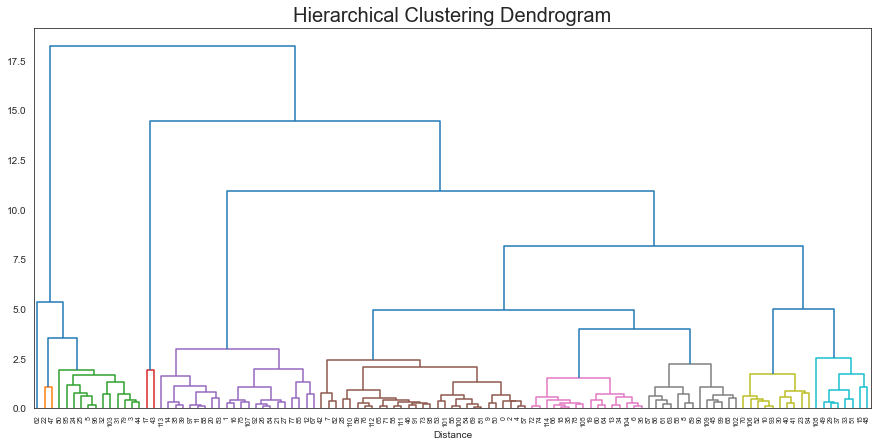

In [64]:
clustering.dendrogram()

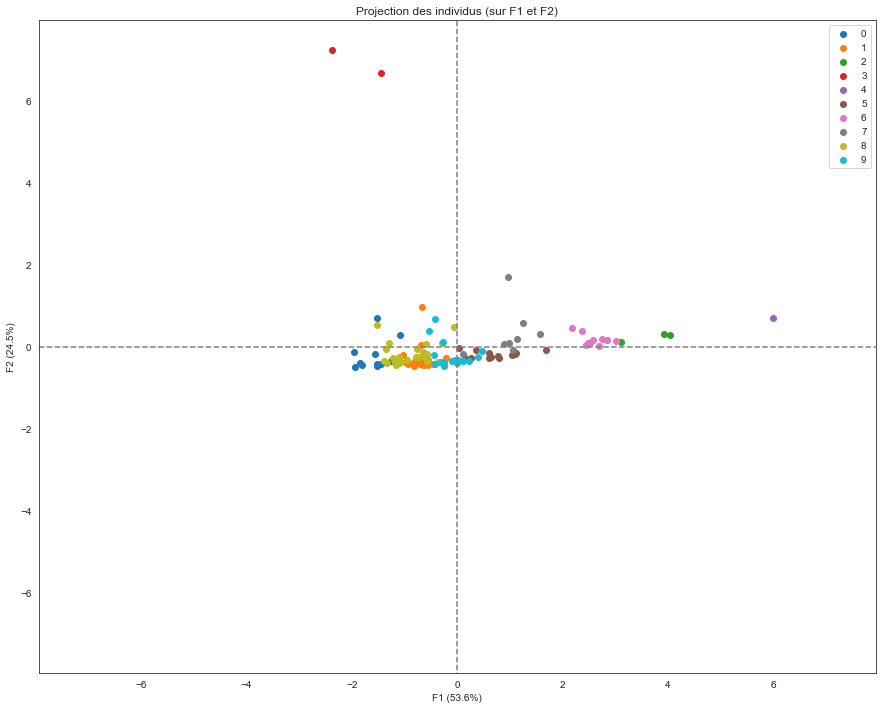

In [65]:
clustering.projection()

In [66]:
clustering.pays_cluster()

,Pays,Code,year,cluster,income,gdpppp,Population,gini
27,Ecuador,ECU,2008,0,99.078545,7560,1.708436e+07,0.50
62,Luxembourg,LUX,2008,4,5780.837400,73127,6.042450e+05,0.33
79,Netherlands,NLD,2008,6,2558.820800,38065,1.705956e+07,0.29
51,Japan,JPN,2008,7,1224.340500,31307,1.272022e+08,0.35
43,India,IND,2007,3,247.838730,2796,1.352642e+09,0.33
22,Cyprus,CYP,2008,2,4406.335400,26273,1.189265e+06,0.32
63,Latvia,LVA,2008,5,609.161250,15596,1.928459e+06,0.37
35,Ghana,GHA,2006,8,63.157047,1380.1182,2.976710e+07,0.43
10,Belarus,BLR,2008,5,913.442140,11651,9.452617e+06,0.28
81,Nepal,NPL,2010,1,192.238780,1048.1808,2.809571e+07,0.33


In [67]:
pays_cluster = clustering.pays_cluster()
pays_cluster = pays_cluster['Code'].tolist()
pays_cluster

['ECU', 'LUX', 'NLD', 'JPN', 'IND', 'CYP', 'LVA', 'GHA', 'BLR', 'NPL']

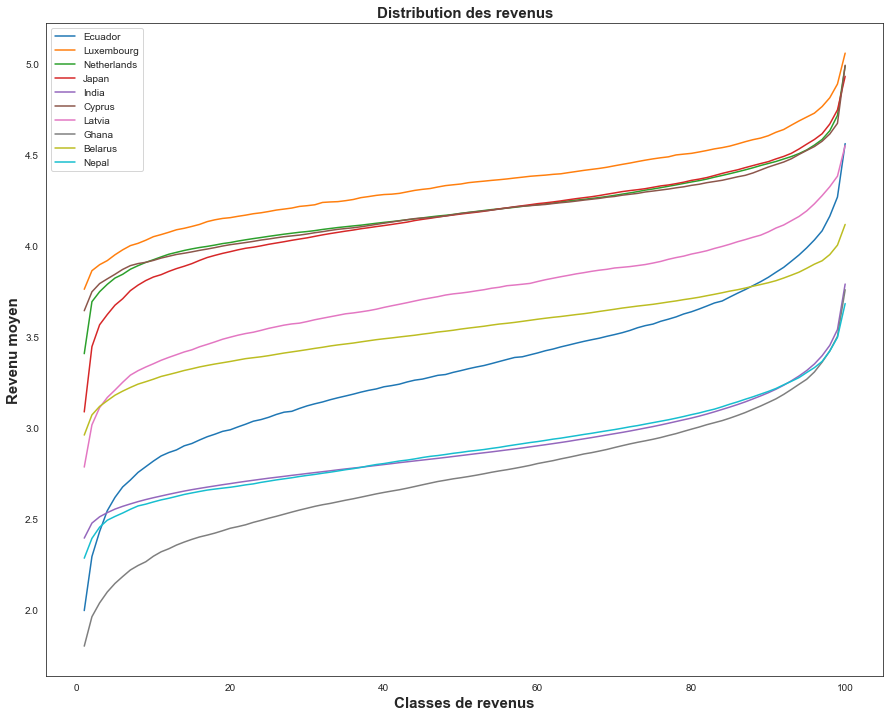

In [68]:
clustering.revenus()

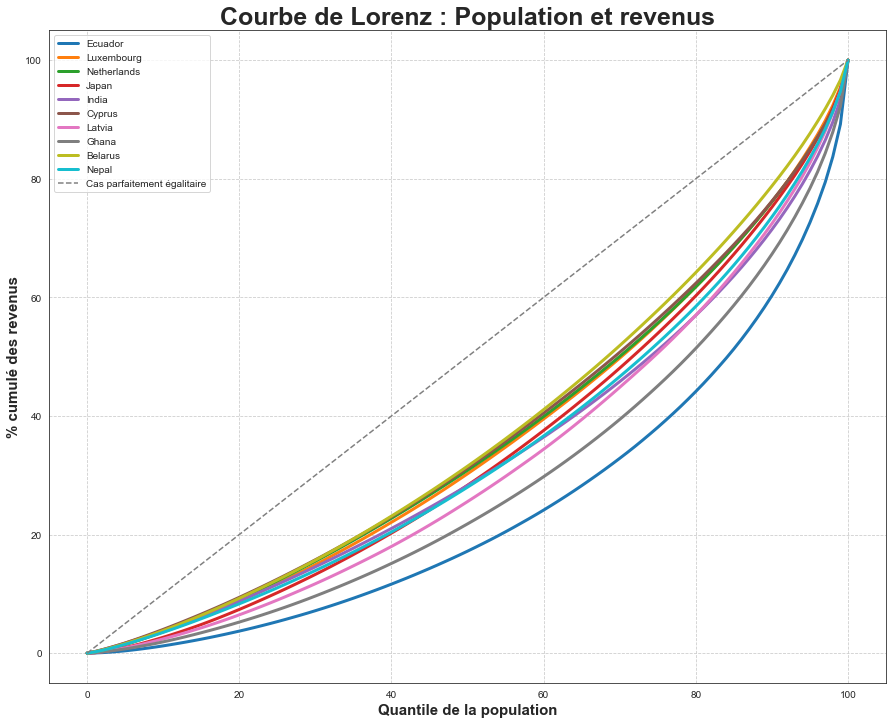

In [69]:
clustering.lorenz()

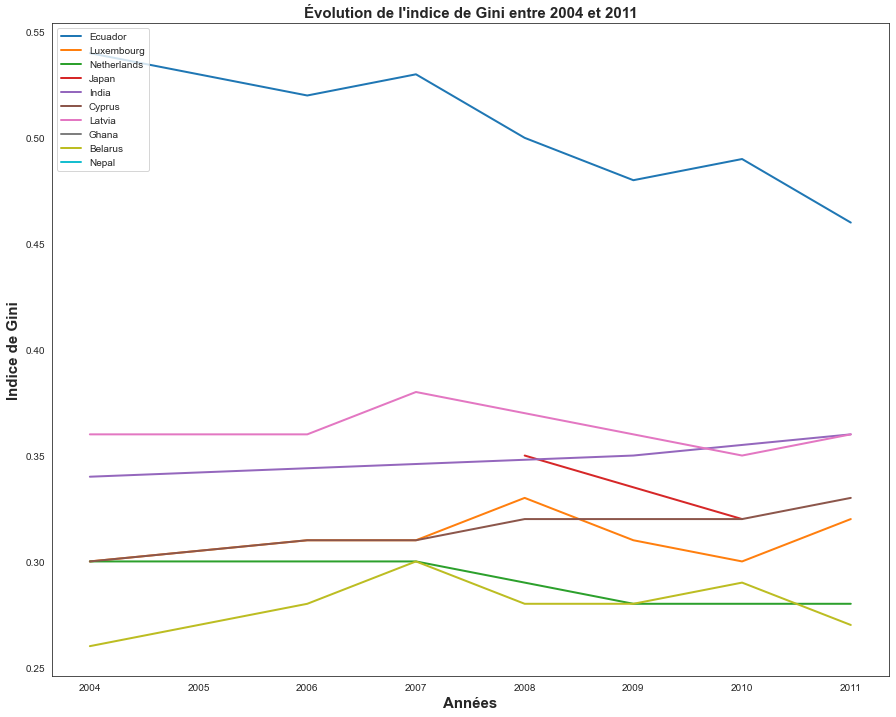

In [70]:
clustering.gini()

In [35]:
#Utilisation de la fonction .rank() pour déterminer la position de chaque pays, dont la France
gini_group = pd.DataFrame(gini_melt.groupby(['Country Code', 'Country Name']).gini.mean()).reset_index()
gini_group['rang'] = gini_group['gini'].rank(ascending=True)

#5 pays ayant l'indice de Gini le plus élevé
print("Les 5 pays avec l'indice de Gini le plus élevé : " )
print("  ")
print(gini_group.sort_values(by='gini', ascending=False).head())
print("  ")
print("  ")
#5 pays ayant l'indice de Gini le plus faible
print("Les 5 pays ayant l'indice de Gini le plus faible : ")
print("  ")
print(gini_group.sort_values(by='gini', ascending=True).head())
print("  ")
print("  ")
#Position de la France 
print("La position de la France : ")
print("  ")
print(gini_group[gini_group['Country Name'] == 'France'])

Les 5 pays avec l'indice de Gini le plus élevé : 
  
    Country Code              Country Name  gini   rang
141          ZAF              South Africa  0.63  144.0
94           NAM                   Namibia  0.61  143.0
26           BWA                  Botswana  0.60  142.0
27           CAF  Central African Republic  0.56  140.5
35           COM                   Comoros  0.56  140.5
  
  
Les 5 pays ayant l'indice de Gini le plus faible : 
  
    Country Code     Country Name      gini  rang
120          SVN         Slovenia  0.245714   1.0
41           DNK          Denmark  0.261429   2.0
119          SVK  Slovak Republic  0.262857   3.0
39           CZE   Czech Republic  0.265714   4.0
134          UKR          Ukraine  0.268571   5.0
  
  
La position de la France : 
  
   Country Code Country Name      gini  rang
50          FRA       France  0.322857  35.0


# Mission 3

1. Générez un grand nombre de réalisations d'une variable selon une loi normale. Le choix de la moyenne et de l'écart-type n'auront pas d'incidence sur le résultat final. Il doit être supérieur à 1000 fois le nombre de quantiles.


In [36]:
#Chargement et traitement des données GDIM
gdim = pd.read_csv(cwd + '/data/gdim.csv')
gdim = gdim[['countryname', 'iso3', 'region', 'IGEincome']]
gdim.rename(columns={'countryname': 'Country Name', 'iso3' : 'Country Code'}, inplace=True)
gdim.drop_duplicates(inplace=True)
gdim.drop_duplicates(subset=['Country Name'], keep = 'last', inplace=True)


#Isolement des pays sans valeur pour la variable 'IGEincome'
missing_gdim = gdim[gdim['IGEincome'].isna()]
display(missing_gdim.tail())

#Identification des pays sans valeur pour la variable 'IGEincome'
missing_countries_gdim = missing_gdim['Country Code'].unique()
missing_countries_gdim = list(missing_countries_gdim)
print("  ")
print(str(len(missing_countries_gdim)) +" pays sans donnée GDIM")

#Visualisation des régions concernées 
list(missing_gdim.region.unique())

,Country Name,Country Code,region,IGEincome
6298,"Venezuela, RB",VEN,Latin America & Caribbean,NaN
6366,Vanuatu,VUT,East Asia & Pacific,NaN
6378,West Bank and Gaza,PSE,Middle East & North Africa,NaN
6390,"Yemen, Rep.",YEM,Middle East & North Africa,NaN
6492,Zambia,ZMB,Sub-Saharan Africa,NaN


  
77 pays sans donnée GDIM


['South Asia',
 'Sub-Saharan Africa',
 'Latin America & Caribbean',
 'Europe & Central Asia',
 'Middle East & North Africa',
 'High income',
 'East Asia & Pacific']

In [37]:
#Visualisation des pays concernés par la région 'High income'
missing_gdim[missing_gdim['region'] == 'High income']['Country Name'].unique()

#Boucle itérative afin d'imputer les valeurs NaN sur la variable 'IGEincome'
for code in missing_countries_gdim :
    if list(gdim.loc[gdim['Country Code'] == code, 'region']) == ['South Asia']:
        gdim.loc[gdim['Country Code'] == code, 'IGEincome'] = 0.50
    elif list(gdim.loc[gdim['Country Code'] == code, 'region']) == ['Sub-Saharan Africa']:
        gdim.loc[gdim['Country Code'] == code, 'IGEincome'] = 0.66
    elif list(gdim.loc[gdim['Country Code'] == code, 'region']) == ['Latin America & Caribbean']:
        gdim.loc[gdim['Country Code'] == code, 'IGEincome'] = 0.66
    elif list(gdim.loc[gdim['Country Code'] == code, 'region']) == ['Europe & Central Asia']:
        gdim.loc[gdim['Country Code'] == code, 'IGEincome'] = 0.40                                                               
    elif list(gdim.loc[gdim['Country Code'] == code, 'region']) == ['East Asia & Pacific']:
        gdim.loc[gdim['Country Code'] == code, 'IGEincome'] = 0.50
    else : gdim.loc[gdim['Country Code'] == code, 'IGEincome'] =  0.40

#Jointure avec notre dataframe 'df' et celui obtenu 'gdim'
#'IGEincome' sera renommé en 'pj'
df_income_mobility = pd.merge(df, gdim[['Country Code', 'IGEincome']], how='left', on='Country Code')
df_income_mobility.rename(columns={'IGEincome': 'pj'}, inplace=True)

#Vérification des éventuelles valeurs manquantes
last_list_missing_countries = list(df_income_mobility[df_income_mobility['pj'].isna()]['Country Name'].unique())
last_list_missing_countries

['Kosovo', 'Syrian Arab Republic']

In [38]:
#Imputation des 2 dernières valeurs NaN dans le dataframe 
for country in last_list_missing_countries :
    if list(df_income_mobility[df_income_mobility['Country Name'] == "Kosovo"]):
        df_income_mobility.loc[df_income_mobility['Country Name'] == country, 'pj'] = 0.40
    else : 
        df_income_mobility.loc[df_income_mobility['Country Name'] == country, 'pj'] = 0.50
        
#Dernière validation de la complétude du dataframe "df_income_mobility"
df_income_mobility.isna().any()

Country Code    False
year            False
quantile        False
nb_quantiles    False
income          False
gdpppp          False
Country Name    False
Population      False
gini            False
pj              False
dtype: bool

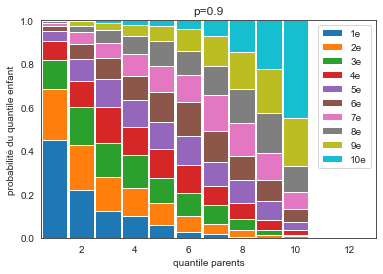

[[0.448 0.219 0.125 0.099 0.06  0.026 0.018 0.003 0.001 0.001]
 [0.236 0.206 0.155 0.132 0.1   0.074 0.046 0.033 0.013 0.005]
 [0.133 0.176 0.158 0.148 0.114 0.106 0.086 0.051 0.021 0.007]
 [0.088 0.121 0.162 0.13  0.134 0.13  0.086 0.075 0.049 0.025]
 [0.045 0.102 0.131 0.127 0.124 0.133 0.114 0.103 0.085 0.036]
 [0.022 0.067 0.096 0.11  0.138 0.155 0.141 0.112 0.099 0.06 ]
 [0.017 0.054 0.067 0.101 0.122 0.126 0.166 0.152 0.12  0.075]
 [0.007 0.03  0.062 0.083 0.115 0.108 0.133 0.155 0.188 0.119]
 [0.002 0.02  0.031 0.05  0.067 0.101 0.136 0.171 0.2   0.222]
 [0.002 0.005 0.013 0.02  0.026 0.041 0.074 0.145 0.224 0.45 ]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.099


In [39]:
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    
    #(Question1)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    
    #(Question2)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
    
#(Question 3 et 4)Pour chacun des n individus générés, les classes de revenu sont calculées selon ychild et yparent    
def quantiles(l, nb_quantiles):
    size = len(l)
    assert(size!=0)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

#(Question 5)
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

#(Question 6)
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 10       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
#(Question 6)
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)

c_i_child = 5 
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

In [40]:
#Visualisation des 5 premières classes de revenu enfants et parents
display(sample.head())
display(sample.shape)

,y_child,y_parents,c_i_child,c_i_parent
0,4.165691,2.474389,9,9
1,1.811625,1.740081,7,8
2,1.217649,0.583008,6,3
3,0.241435,0.372667,2,2
4,0.240931,0.193098,2,1


(10000, 4)

In [41]:
#(Question 7)
#Pour éviter toute confusion, les individus générés sont supprimés (car inutiles pour la suite)
#seules les distributions conditionnelles sont conservées.
sample = sample.iloc[:, 2:]

#(Question 8)
#Nouvel échantillon : 500 fois plus grand que celui de la World Income Distribution
#Cet échantillon sera nommé "df_wid500", clone représentatif des individus de la WID
df_wid = df_income_mobility[['Country Code', 'Country Name', 'quantile', 'Population', 
                                'income', 'income', 'gini', 'pj']]

df_wid500 = pd.concat([df_wid]*500, ignore_index=True)

#(Question 9)
#Attribution des classes parents aux 500 individus de chaque pays
#Coefficient d'élasticité / code pays
country_income = df_income_mobility[['Country Code', 'pj']]

#Création d'une liste qui va de 1 à 101
liste_quantile = [i for i in range(1, 101)]

#Création de la liste des 116 pays qui sont dans la base
liste_pays = df_wid500["Country Code"].drop_duplicates().to_list()

In [42]:
def c_parent (l_pays, l_quantile, multiplicateur, nb_quantiles_all):
    l_df = []
    for pays in tqdm(l_pays):
        for quantile in l_quantile:
            df_wid_mult = df_wid.copy()
            df_wid_mult.rename(columns={'Country Name': 'country', 'Country Code': 'country_code'},  inplace=True)
            df_income_avg = df_wid_mult[['country_code','income']].groupby('country_code').mean().reset_index()
            df_income_avg.rename(columns={'income':'income_avg'}, inplace=True)
            df_wid_mult = df_wid_mult.merge(df_income_avg, how='left', on='country_code')
            df_c_i_parent = pd.concat([df_wid_mult]*multiplicateur, ignore_index=True)
            df_c_i_parent = df_c_i_parent[(df_c_i_parent["quantile"]== quantile)&(df_c_i_parent["country_code"]== pays)]
            df_c_i_parent.rename(columns={'quantile': 'c_i_child'},  inplace=True)
            
            pj_c_parent = df_c_i_parent.pj.iloc[0]
            y_child, y_parents = generate_incomes(n, pj_c_parent)
            sample_final = compute_quantiles(y_child, y_parents, nb_quantiles_all)
            cd = conditional_distributions(sample_final, nb_quantiles_all)

            distribuition_parent = np.floor(cd[quantile-1]*multiplicateur)
            sum_dp = sum(distribuition_parent)
            diff = int(multiplicateur - sum_dp)
            quantite_quantile = list(distribuition_parent)
            
            df_distribution = pd.DataFrame(quantite_quantile, columns =['qnt'])
            df_distribution = df_distribution.sort_values(by = 'qnt', ascending = False).reset_index()
            df_distribution['qnt'] = [int(i) if n >= diff else int(i+1) for n, i in enumerate(distribuition_parent)]
           
            df_c_i_parent['c_i_parent'] = NaN
            nn = 0
            mm = 0
            for i in range(len(df_distribution)):
                mm = mm + df_distribution['qnt'][i]
                df_c_i_parent.iloc[nn:mm, -1] = df_distribution['index'][i] + 1
                nn = nn + df_distribution['qnt'][i]
            l_df.append(df_c_i_parent)
        df = pd.concat(l_df)
        df = df.loc[:,~df.columns.duplicated()]
        df = df.reset_index()
        df.drop(['index'],  axis=1, inplace=True)
    return df

In [43]:
c_parent(['FRA', 'ECU', 'VEN'], [1], 100, 100)

100%|██████████| 3/3 [00:18<00:00,  6.08s/it]


,country_code,country,c_i_child,Population,income,gini,pj,income_avg,c_i_parent
0,FRA,France,1,64990511.0,2958.30400,0.33,0.357105,18309.407545,2.0
1,FRA,France,1,64990511.0,2958.30400,0.33,0.357105,18309.407545,2.0
2,FRA,France,1,64990511.0,2958.30400,0.33,0.357105,18309.407545,2.0
3,FRA,France,1,64990511.0,2958.30400,0.33,0.357105,18309.407545,2.0
4,FRA,France,1,64990511.0,2958.30400,0.33,0.357105,18309.407545,2.0
...,...,...,...,...,...,...,...,...,...
295,VEN,Venezuela (Bolivarian Republic of),1,28887118.0,171.89282,0.43,0.660000,3167.147724,72.0
296,VEN,Venezuela (Bolivarian Republic of),1,28887118.0,171.89282,0.43,0.660000,3167.147724,70.0
297,VEN,Venezuela (Bolivarian Republic of),1,28887118.0,171.89282,0.43,0.660000,3167.147724,83.0
298,VEN,Venezuela (Bolivarian Republic of),1,28887118.0,171.89282,0.43,0.660000,3167.147724,86.0


In [44]:
#Calcul du df x500 avec les 100 quantiles
if os.path.isfile(cwd + '/df_m3.pic'):
    df_mission3 = pickle.load(open(cwd + '/df_m3.pic', 'rb'))
else:
    df_mission3 = c_parent(liste_pays, liste_quantile, 500, 100)
    with open(cwd + '/df_m3.pic', 'wb') as f:
        pickle.dump(df_mission3, f)
df_mission3

,Country Code,Country Name,c_i_child,Population,income,gini,pj,c_i_parent
0,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2.0
11600,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2.0
23200,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2.0
34800,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2.0
46400,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2.0
...,...,...,...,...,...,...,...,...
5753598,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,1.0
5765198,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,1.0
5776798,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,1.0
5788398,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,1.0


In [45]:
#Calcul du df x10 avec les 100 quantiles
if os.path.isfile(cwd + '/final_df_dix.pic'):
    final_df_dix = pickle.load(open(cwd + '/final_df_dix.pic', 'rb'))
else:
    final_df_dix = c_parent(liste_pays, liste_quantile, 10, 100)
    with open(cwd + '/final_df_dix.pic', 'wb') as f:
        pickle.dump(final_df_dix, f)
final_df_dix

,country_code,country,c_i_child,Population,income,gini,pj,income_avg,c_i_parent
0,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
1,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
2,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
3,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,2.0
4,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,2.0
...,...,...,...,...,...,...,...,...,...
115995,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,71.0
115996,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,70.0
115997,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,69.0
115998,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,68.0


In [46]:
#Calcul du df x50 avec les 100 quantiles
if os.path.isfile(cwd + '/final_df_50.pic'):
    final_df_50 = pickle.load(open(cwd + '/final_df_50.pic', 'rb'))
else:
    final_df_50 = c_parent(liste_pays, liste_quantile, 50, 100)
    with open(cwd + '/final_df_50.pic', 'wb') as f:
        pickle.dump(final_df_50, f)
final_df_50

,country_code,country,c_i_child,Population,income,gini,pj,income_avg,c_i_parent
0,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
1,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
2,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
3,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
4,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
...,...,...,...,...,...,...,...,...,...
579995,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,51.0
579996,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,51.0
579997,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,51.0
579998,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,51.0


In [47]:
#Calcul du df x100 avec les 100 quantiles
if os.path.isfile(cwd + '/final_df_100.pic'):
    final_df_100 = pickle.load(open(cwd + '/final_df_100.pic', 'rb'))
else:
    final_df_100 = c_parent(liste_pays, liste_quantile, 100, 100)
    with open(cwd + '/final_df_100.pic', 'wb') as f:
        pickle.dump(final_df_100, f)
final_df_100

,country_code,country,c_i_child,Population,income,gini,pj,income_avg,c_i_parent
0,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
1,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
2,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
3,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
4,ALB,Albania,1,2882740.0,728.89795,0.30,0.815874,2994.829902,1.0
...,...,...,...,...,...,...,...,...,...
1159995,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,51.0
1159996,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,51.0
1159997,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,51.0
1159998,COD,Congo,100,84068091.0,2243.12260,0.44,0.707703,276.016044,51.0
